In [ ]:
# importing modules
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def import_files(data_path):
    """
    Import the files and join the features with the labels to obtain a single dataframe
    """
    users = os.path.join(data_path, 'users')
    users_features = os.path.join(data_path, 'users_features')

    coded_ids = pd.read_csv(os.path.join(users,'coded_ids.csv')).set_index('coded_id')
    coded_ids_labels_train = pd.read_csv(os.path.join(users,'coded_ids_labels_train.csv')).set_index('coded_id')
    coded_ids = coded_ids.join(coded_ids_labels_train)
    coded_ids.reset_index(inplace=True)
    coded_ids.set_index('user_id', inplace=True)

    features = pd.read_csv(os.path.join(users_features, 'features.csv')).set_index('user_id')
    # features_names = pd.read_csv(os.path.join(users_features, 'features_names.txt'), header=None)

    data = features.join(coded_ids)
    data.reset_index(inplace=True, drop=True)
    data.set_index('coded_id', inplace=True)
    data.sort_index(inplace=True)

    return data

def get_clean_data(data_path):
    """
    Clean the dataset by:
    1. encode categorical variable
    2. remove unnecessary features
    3. fill null values
    4. convert datetime to timestamp
    """
    data = import_files(data_path)

    encoder = LabelEncoder()
    data['lang'] = encoder.fit_transform(data['lang'])
    data['time_zone'] = encoder.fit_transform(data['time_zone'].astype(str))
    data['date_newest_tweet'] = pd.to_datetime(data['date_newest_tweet']).astype('int64') // 10 ** 9
    data['date_oldest_tweet'] = pd.to_datetime(data['date_oldest_tweet']).astype('int64') // 10 ** 9
    data['utc_offset'] = data['utc_offset'].fillna(0)

    cols_to_remove = ['avg_intertweet_times',
                      'max_intertweet_times',
                      'min_intertweet_times',
                      'std_intertweet_times',
                      'followers_count_minus_2002',
                      'friends_count_minus_2002',
                      'spam_in_screen_name']
    data.drop(cols_to_remove, axis=1, inplace=True)

    return data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/Data_Mining/Social_spammers_dataset'
data = get_clean_data(data_path)
train = data[data.columns][data.label.notnull()].copy()
train

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,date_oldest_tweet,default_profile,default_profile_image,diversity_index_of_hashtags,diversity_index_of_mentions,diversity_index_of_sources,diversity_index_of_urls,favourites_count,followees_per_followers_sq,followers_count,followers_per_followees,friends_count,hashtags_used_on_average,lang,len_description,len_screen_name,max_intertweet_times_seconds,max_nb_characters_per_tweet,max_nb_favourites_per_tweet,max_nb_hashtags_per_tweet,max_nb_hashtags_per_word_in_the_tweet,max_nb_mentions_per_tweet,max_nb_mentions_per_word_in_the_tweet,max_nb_retweets_per_tweet,max_nb_symbols_per_tweet,max_nb_symbols_per_word_in_the_tweet,max_nb_urls_per_tweet,max_nb_urls_per_word_in_the_tweet,max_nb_words_per_tweet,mean_nb_characters_per_tweet,mean_nb_favourites_per_tweet,...,proportion_replies,proportion_retweets,replicates,replicates_top_20,reputation,similarity,similarity_top_20,sources_used_on_average,statuses_count,std_intertweet_times_seconds,std_nb_characters_per_tweet,std_nb_favourites_per_tweet,std_nb_hashtags_per_tweet,std_nb_hashtags_per_word_in_the_tweet,std_nb_mentions_per_tweet,std_nb_mentions_per_word_in_the_tweet,std_nb_retweets_per_tweet,std_nb_symbols_per_tweet,std_nb_symbols_per_word_in_the_tweet,std_nb_urls_per_tweet,std_nb_urls_per_word_in_the_tweet,std_nb_words_per_tweet,temporal_bin_0,temporal_bin_1,temporal_bin_2,temporal_bin_3,temporal_bin_4,temporal_bin_5,temporal_bin_6,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,utc_offset,label
coded_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.640,1.000,2.000,382.405,42.353,2965,135496.0,625,1494543397,1455859834,True,False,5.000,1.000,1.046,9.421,0,0.016,38,1.652,23,1.000,4,93,11,13314078.0,119,3,3,0.250,2,0.133,3,0,0.0,1,0.167,25,74.227500,0.057500,...,0.003,0.000,7,0.0,0.623,0.337,0.323,200.000,660,1.050251e+06,16.317651,0.306910,0.165359,0.013,0.099875,0.007,0.242436,0.0,0.0,0.049937,0.025,3.180943,0.133,0.188,0.152,0.120,0.135,0.107,0.080,0.085,97,3.233333,51,0.223,1,3,19,23.471,0.0,1.0
2,0.475,2.605,2.292,286.480,1.327,1855,182320.0,1133,1498100394,1400194801,True,False,31.095,125.673,1.878,165.753,333,0.010,227,0.439,517,1.421,0,46,8,36767585.0,140,2,5,0.200,4,0.333,131447,0,0.0,2,0.250,36,100.719331,0.013011,...,0.056,0.507,34,6.0,0.305,0.349,0.415,179.333,2686,1.617904e+06,31.165663,0.128683,0.493084,0.025,0.574924,0.049,9246.874302,0.0,0.0,0.495401,0.029,6.222263,0.154,0.043,0.154,0.191,0.086,0.095,0.128,0.149,234,7.800000,81,1.448,7,13,3,1.128,0.0,0.0
3,1.805,13.543,35.730,395.005,1.000,1846,48013.0,220,1538449886,1494121639,True,False,19.051,12.650,1.005,29.000,376,0.005,270,0.738,366,3.185,0,0,8,600413.0,140,1,9,0.360,4,0.500,225509,0,0.0,2,0.154,35,102.178841,0.002519,...,0.139,0.854,27,0.0,0.425,0.276,0.327,198.500,19037,8.770326e+04,37.414564,0.050125,1.192264,0.056,0.463750,0.076,12009.243486,0.0,0.0,0.269721,0.018,8.057965,0.123,0.088,0.106,0.161,0.171,0.131,0.146,0.073,1,0.033333,81,10.313,20,8,0,1.000,0.0,0.0
4,0.259,1.000,57.474,62.200,32.826,1838,336007.0,715,1530522498,1456169220,True,False,7.000,1.322,2.974,5.605,2,0.140,11,0.647,17,1.000,4,0,9,20482588.0,141,2,3,0.150,1,0.125,1,0,0.0,2,0.250,30,83.843243,0.048649,...,0.022,0.000,60,1.0,0.393,0.324,0.378,37.000,185,1.688851e+06,24.876827,0.260583,0.282222,0.013,0.491981,0.032,0.103411,0.0,0.0,0.220498,0.035,5.513063,0.108,0.119,0.103,0.184,0.211,0.059,0.146,0.070,4,0.133333,5,0.101,10,1,20,1.736,3600.0,1.0
6,7.491,4.300,7.408,395.005,1.022,1817,11703.0,53,1538486464,1513634375,False,False,70.460,66.143,1.005,87.044,138,0.000,1604,1.848,868,1.674,0,100,7,358906.0,144,11,8,0.333,12,0.500,1

**Calcuate correlation between label and each column**

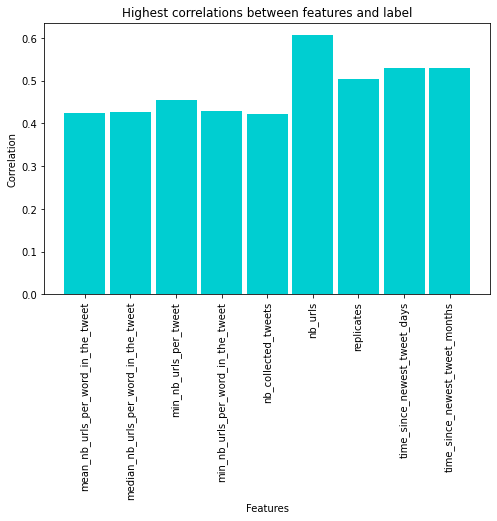

In [ ]:
import math
import matplotlib.pyplot as plt 

x_list = []
y_list = []

for column in train:
    if (column != 'label'):
        corre = train[column].corr(train['label'])
        if(corre> 0.4):
            x_list.append(column)
            y_list.append(corre)
plt.subplots(figsize=(8, 5))

plt.bar(x_list, y_list, tick_label = x_list, width = 0.9, color = ['darkturquoise'])
  
plt.xlabel('Features') 
plt.ylabel('Correlation')
plt.title('Highest correlations between features and label') 
plt.xticks(rotation='vertical')
  
plt.show()

**Calculate Feature Importance by Scikit Learn**

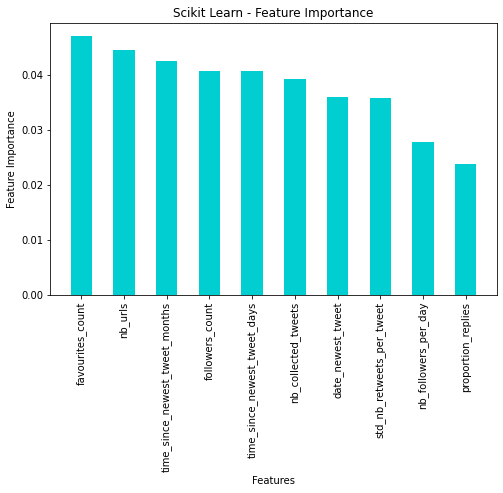

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df


rf =  RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)
rf.fit(train.iloc[:,:-1], train['label'])

base_imp = imp_df(train.iloc[:,:-1].columns, rf.feature_importances_)

# All data
# x_list = base_imp['feature']
# y_list = base_imp['feature_importance']

# First 10 data
x_list = base_imp['feature'][:10]
y_list = base_imp['feature_importance'][:10]

plt.subplots(figsize=(8, 5))
plt.bar(x_list, y_list, tick_label = x_list, width = 0.5, color = ['darkturquoise'])  
plt.xlabel('Features') 
plt.ylabel('Feature Importance') 
plt.title('Scikit Learn - Feature Importance') 
plt.xticks(rotation='vertical')
  
plt.show()

**Predictive Power Score (PPS)**

In [ ]:
pip install ppscore

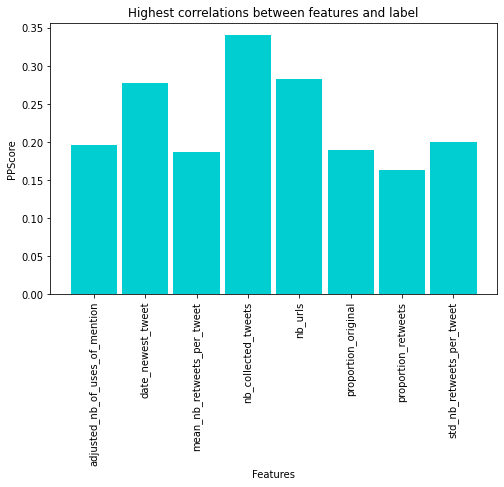

In [ ]:
import ppscore as pps

x_list = []
y_list = []

for column_name, column_series in train.iloc[:, :-1].iteritems():
  d = pps.score(train, column_name, "label")
  if("ppscore" in d):
    if(d['ppscore'] > 0.15):
      x_list.append(column_name)
      y_list.append(d['ppscore'] )
  else:  
    x_list.append(column_name)
    y_list.append(0)

plt.subplots(figsize=(8, 5))

plt.bar(x_list, y_list, tick_label = x_list, width = 0.9, color = ['darkturquoise'])
  
plt.xlabel('Features') 
plt.ylabel('PPScore')
plt.title('Highest correlations between features and label') 
plt.xticks(rotation='vertical')
  
plt.show()